In [58]:
import warnings
warnings.filterwarnings('ignore')
import spacy
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import matplotlib.pyplot as plt
from keras.utils import plot_model,multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model,Sequential
from keras.models import load_model
from keras.layers import Input,GlobalAveragePooling2D,Layer,InputSpec
from keras.layers.core import Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
import keras.backend as K
import keras.layers as kl
from keras.preprocessing import sequence
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from time import time
from sentence_transformers import SentenceTransformer
import pickle
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.losses import sparse_categorical_crossentropy
from PIL import Image
# from AttentionModule import SelfAttention, SoftAttention
import os
visible_gpu_devices = '2'
os.environ["CUDA_VISIBLE_DEVICES"]=visible_gpu_devices
# import cv2
from tqdm.notebook import tqdm
import AttentionMed as AM
import NetworkModules as NM
from importlib import reload
reload(AM)
reload(NM)
from time import time,localtime,strftime
from ipywidgets import IntProgress
# from coord import CoordinateChannel2D

In [2]:
n_gpu=len(visible_gpu_devices.split(','))
n_cpu=1
tf_config= tf.ConfigProto(device_count = {'GPU': n_gpu , 'CPU': n_cpu})
tf_config.gpu_options.allow_growth=True
s=tf.Session(config=tf_config)
K.set_session(s)

In [3]:
# Choose the top 2000 words from the vocabulary
top_k = 2000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')


In [4]:
# nlp = spacy.load('en_core_web_md')

In [5]:
path=os.getcwd() #Get the path
path

'/media/MyDataStor1/mshaikh2/project_xray/ChestXRay/notebooks'

In [6]:
proj_ds=pd.read_csv(path+'/../dataset/indiana_projections.csv')
repo_ds=pd.read_csv(path+'/../dataset/indiana_reports.csv')

display(proj_ds.head(50),proj_ds.shape)
display(repo_ds.sort_values(by='uid').head(),repo_ds.shape)

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal
5,3,3_IM-1384-2001.dcm.png,Lateral
6,4,4_IM-2050-1001.dcm.png,Frontal
7,4,4_IM-2050-2001.dcm.png,Lateral
8,5,5_IM-2117-1003002.dcm.png,Frontal
9,5,5_IM-2117-1004003.dcm.png,Lateral


(7466, 3)

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


(3851, 8)

In [7]:
f_proj_ds = proj_ds[proj_ds.projection=='Frontal']
f_proj_ds = f_proj_ds.sort_values(by='uid')
display(f_proj_ds.head())
f_proj_ds.shape

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
2,2,2_IM-0652-1001.dcm.png,Frontal
4,3,3_IM-1384-1001.dcm.png,Frontal
6,4,4_IM-2050-1001.dcm.png,Frontal
8,5,5_IM-2117-1003002.dcm.png,Frontal


(3818, 3)

In [8]:
c_repo_ds = repo_ds.dropna(subset=['findings','impression'],how='any')
display(c_repo_ds.head())
c_repo_ds.shape

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
5,6,normal,normal,"PA and Lateral Chest. XXXX, XXXX at XXXX",Evaluate for infection,"XXXX, XXXX",Heart size and mediastinal contour are within ...,No acute cardiopulmonary findings.


(3331, 8)

In [9]:
merged_ds = pd.merge(left=c_repo_ds,right=proj_ds,on='uid',how='inner')
display(merged_ds.head())
# merged_ds = merged_ds[merged_ds.projection=='Frontal']
# merged_ds.shape

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-4001.dcm.png,Frontal
1,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-3001.dcm.png,Lateral
2,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-1001.dcm.png,Frontal
3,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-2001.dcm.png,Lateral
4,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,4_IM-2050-1001.dcm.png,Frontal


In [10]:
d = merged_ds[['filename','findings']].T.values
t_arr = []
for t in d[1]:
    t_ = '<startseq> ' + t[:300] + ' <endseq>' 
    t_arr.append(t_)
    
    

In [11]:
for a,b in zip(d[1],t_arr):
    print(a,b)
    break

The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax. <startseq> The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax. <endseq>


In [12]:
# chars = []
# char_count = {}
# finding_len = []
# max_len=0
# for finding in c_repo_ds.findings:
#     tokens = finding.lower()
#     for i in list("[-<>:.,()]/"):
#         tokens = tokens.replace(i,' ')
#     tokens=tokens.strip()
#     if max_len<len(tokens):
#         max_len=len(tokens)
#     finding_len.append(len(tokens))
#     chars+=tokens
# for impr in c_repo_ds.impression:
#     tokens = impr.lower()
#     for i in list("[-<>:.,()]/"):
#         tokens = tokens.replace(i,' ')
#     tokens=tokens.strip()
#     chars+=tokens
#     if max_len<len(tokens):
#         max_len=len(tokens)
#     finding_len.append(len(tokens))
# print(len(list(set(chars))))
# for char in chars:
#     if char not in char_count.keys():
#         char_count[char]=1
#     else:
#         char_count[char]+=1
# df_ccount = pd.DataFrame()
# df_ccount['chars']=char_count.keys()
# df_ccount['c_count']=char_count.values()
# df_ccount = df_ccount.sort_values(by='c_count',ascending=False).reset_index()
# display(df_ccount.head(10))
# df_ccount['index'].max(),max_len
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# sent_len_arr=[]
# wo_len_arr = []
# for row in tqdm(merged_ds['impression'].values):
#     doc = nlp(row)
#     sentences = [sent.string.strip() for sent in doc.sents]
#     sent_len_arr.append(len(sentences))
#     sentence = ' '.join(sentences[:7])
#     sdoc = nlp(sentence)
#     ls_sdoc = [str(x) for x in list(sdoc)]
#     wo_len_arr.append(len(ls_sdoc))

In [14]:
# df_sent_len = pd.DataFrame(sent_len_arr,columns=['count'])
# df_word_len = pd.DataFrame(wo_len_arr,columns=['count'])
# df_sent_len.shape,df_word_len.shape

In [15]:
# df_word_len.describe()

In [16]:
# df_sent_len[df_sent_len['count']>7].shape
# df_word_len[df_word_len['count']>20]


In [17]:
# ch_to_co = df_ccount
# ch_to_co.index = ch_to_co.chars
# ch_to_co = ch_to_co['index'].to_dict()
# display(ch_to_co)
# co_to_ch = df_ccount
# co_to_ch.index = co_to_ch['index']
# co_to_ch = co_to_ch['chars'].to_dict()
# display(co_to_ch)

In [18]:
# tokens = nlp('startseq ' 
#              + ' '.join(c_repo_ds.impression.values).lower().replace('/',' ')
#              + ' endseq.' 
#              + ' startseq' 
#              + ' '.join(c_repo_ds.findings.values).lower().replace('/',' ')
#              + ' endseq.')
img_name_vector=d[0]
train_captions = t_arr

In [19]:
# vocab = [str(x) for x in tokens]
# vocab

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [20]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [21]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [22]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [23]:
cap_vector.shape

(6457, 60)

In [24]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [25]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(5165, 5165, 1292, 1292)

In [26]:
img_name_train[0]

'2937_IM-1339-1001.dcm.png'

In [27]:
tokenizer.sequences_to_texts(cap_train[0:1])

['<startseq> the heart size and mediastinal contours appear within normal limits no focal airspace consolidation pleural effusion or pneumothorax no acute bony abnormalities <endseq> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']

In [28]:
tokenizer.word_index

{'<unk>': 1,
 'the': 2,
 'no': 3,
 'are': 4,
 'is': 5,
 'normal': 6,
 '<startseq>': 7,
 '<endseq>': 8,
 'and': 9,
 'pleural': 10,
 'or': 11,
 'pneumothorax': 12,
 'there': 13,
 'of': 14,
 'xxxx': 15,
 'effusion': 16,
 'heart': 17,
 'lungs': 18,
 'size': 19,
 'focal': 20,
 'within': 21,
 'clear': 22,
 'limits': 23,
 'in': 24,
 'pulmonary': 25,
 'consolidation': 26,
 'silhouette': 27,
 'right': 28,
 'mediastinal': 29,
 'cardiomediastinal': 30,
 'airspace': 31,
 'left': 32,
 'lung': 33,
 'acute': 34,
 'mediastinum': 35,
 'stable': 36,
 'disease': 37,
 'with': 38,
 'unremarkable': 39,
 'contours': 40,
 'structures': 41,
 'contour': 42,
 'bony': 43,
 'a': 44,
 'changes': 45,
 'spine': 46,
 'thoracic': 47,
 'large': 48,
 'without': 49,
 'cardiac': 50,
 'mild': 51,
 'vascularity': 52,
 'opacity': 53,
 'effusions': 54,
 'appear': 55,
 'seen': 56,
 'calcified': 57,
 'degenerative': 58,
 'osseous': 59,
 'intact': 60,
 'for': 61,
 'evidence': 62,
 'abnormality': 63,
 'upper': 64,
 'opacities': 65

In [29]:
# # word_count = {}
# # for word in vocab:
# #     if word not in word_count.keys():
# #         word_count[word]=1
# #     else:
# #         word_count[word]+=1
# # df_wcount = pd.DataFrame()
# # df_wcount['words']=word_count.keys()
# # df_wcount['w_count']=word_count.values()
# # df_wcount = df_wcount.sort_values(by='w_count',ascending=False).reset_index()
# # df_wcount['index']+=1

# # df_wcount.to_csv('../dataset/vocab_count.csv',index=False)
# df_wcount = pd.read_csv('../dataset/vocab_count.csv')

# display(df_wcount)
# vocab_size=df_wcount.shape[0]
# max_wlen = 60
# print(vocab_size,max_wlen)
max_wlen = calc_max_length(train_seqs)
max_wlen

60

In [30]:
# # df_wcount['w_count'][1353]=3000
# # df_wcount[df_wcount['words']=='endseq']
# # df_wcount.to_csv('../dataset/vocab_count.csv',index=False)
# df_wcount[df_wcount['words']=='..']

In [31]:
# max_count = df_wcount.w_count.max()
# arr_idx_w_count=df_wcount[['index','w_count']].values
# class_weights={}
# for idx,w_count in arr_idx_w_count:
#     class_weights[idx]=np.round((1.0-(w_count/max_count))**10e1,20)+1e-10
# class_weights

In [32]:
# new_words= [word for word in df_wcount['words'].values if not word.isalnum()]
# print(len(new_words),new_words)

In [33]:
# w_to_co = df_wcount
# w_to_co.index = w_to_co.words
# w_to_co = w_to_co['index'].to_dict()
# # print(w_to_co)
# co_to_w = df_wcount
# co_to_w.index = co_to_w['index']
# co_to_w = co_to_w['words'].to_dict()
# # print(co_to_w)

In [34]:
# # df = pd.DataFrame(sorted(finding_len,reverse=True))
# # display(df.head(50))
# # df.plot(kind='hist',figsize=(6,6))
# co_to_w[13]

In [35]:
# embedding_size = 300
# # embedding_matrix = np.zeros((vocab_size+1, embedding_size)) # last one : to cater to empty/-1
# # for word,idx in w_to_co.items():
# #     token = nlp(word)
# #     embedding_matrix[idx] = token.vector
# # embedding_matrix[vocab_size] = np.zeros(embedding_size)
# embedding_matrix = pd.read_pickle('../dataset/initial_emb_mat.p')
# embedding_matrix = embedding_matrix.values
# # print(embedding_matrix.shape)
# # df_emb = pd.DataFrame(embedding_matrix)
# # df_emb.to_pickle('../dataset/initial_emb_mat.p')

# Parameters

In [37]:
img_arch = 'vgg'
text_arch = '1dcnn'
model_name = '{0}_{1}_text_img_attention'.format(img_arch,text_arch)
EPOCHS = 50
lr = 0.0001
img_dropout_rate=0.5
text_dropout_rate=0.5
elu_alpha = 1.0
vocab_size = top_k
bottleneck_units = 512
embedding_size = 256

In [52]:
# w_to_co
# textNet.load_weights('../checkpoints/irv2_1dcnn_attention_text_module.h5')
# imgNet.load_weights('../checkpoints/irv2_1dcnn_attention_img_module.h5')
adam = Adam(
    lr=lr
#     ,clipnorm=1.0
#     ,clipvalue=0.5
)
# kl.CuDNNLSTM()

In [38]:
vocab_size

2000

In [39]:
f = lambda :20
# tokenizer.word_counts

In [40]:
f = np.array([1,2,3,4,5,6,7,8,9])
g = np.ones(9)
np.where(f>5,f,g)

array([1., 1., 1., 1., 1., 6., 7., 8., 9.])

# Model Initialization

In [41]:
def _ctc_lambda_func(args):
    y_true, y_pred, input_length, label_length = args
    cost_fn = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length) 
    return tf.where(cost_fn <= 100.0, cost_fn, tf.ones_like(cost_fn)*100.0)

In [82]:
# for ctc loss
words_input = kl.Input(shape=(max_wlen,),name='words_input')

padding_masks = kl.Input(shape=(max_wlen,1),name='padding_masks')
positional_encoding = Input(shape=(max_wlen,embedding_size),name='positional_encoding')

text_ypred_len = kl.Input((1,),name="ypred_lengths") # this is text_decoder pred output (y_pred) len
text_ytrue_len = kl.Input((1,),name="ytrue_lengths") # this is text_decoder actual (y_true) label len
        

image_input = kl.Input(shape=(256,256,3),name='image_input')

encoded_image = NM.ImageEncoder.model(image_input)
encoded_image = kl.Flatten()(encoded_image)
encoded_image = kl.Dense(2048,activation='relu')(encoded_image)
img_encoder = Model(image_input,encoded_image)
img_encoder.summary()
image_model = kl.Dense(embedding_size, activation='relu')(encoded_image)
image_model = kl.RepeatVector(max_wlen)(image_model)
print(image_model)
    



caption_model = kl.Embedding(vocab_size, embedding_size, input_length=max_wlen)(image_model)
caption_model = kl.CuDNNLSTM(256, return_sequences=True)(caption_model)
caption_model = kl.TimeDistributed(Dense(300))(caption_model)
print(caption_model)

final_model = Sequential([
        kl.Concatenate([image_model, caption_model]),
        kl.Bidirectional(kl.CuDNNLSTM(256, return_sequences=False)),
        kl.Dense(vocab_size),
        kl.Activation('softmax')
    ])

final_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])



# final_model.summary()





# ctc_loss = kl.Lambda(_ctc_lambda_func, output_shape=(1,), name='ctc')([y_true,y_pred,text_ypred_len,text_ytrue_len])


# model = Model([image_input
#                , y_true
#                , words_input
#                , padding_masks
#                , positional_encoding               
#                , text_ytrue_len
#                , text_ypred_len], ctc_loss, name='model')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_reduction_pool (MaxPo (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_58 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     7385

ValueError: "input_length" is 60, but received input has shape (None, 60, 256)

In [59]:
# l = model.get_layer('w2v_emb')
# l.set_weights([embedding_matrix])
# l.trainable = True
# if not os.path.exists('../checkpoints/{0}.h5'.format(model_name)):
#     print('New model {0}.'.format(model_name))
# else:
#     print('Existing model {0}. trained weights will be loaded'.format(model_name))
#     model.load_weights('../checkpoints/{0}.h5'.format(model_name), skip_mismatch=True, by_name=True)
# l.trainable = True
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:42<00:00, 9.56MB/s] 


In [44]:
loss_function =  tf.keras.losses.CategoricalCrossentropy()#,label_smoothing=1e-08)
losses = {
    'ctc':lambda y_true,y_pred:y_pred
}
model.compile(loss=losses, optimizer=adam)
# model.load_weights('../checkpoints/{0}.h5'.format(model_name))

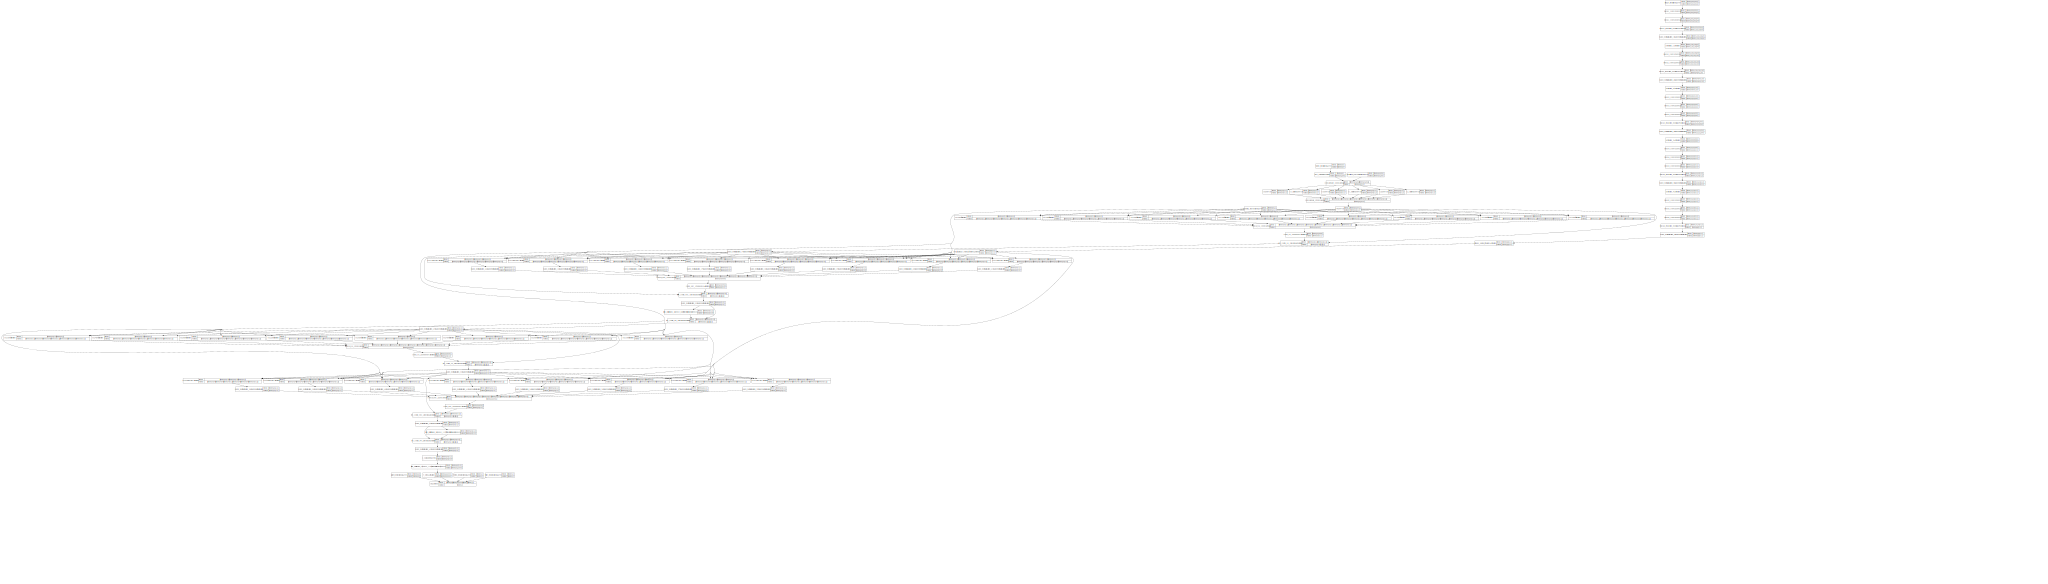

In [45]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True,dpi=60).create(prog='dot', format='svg'))

In [46]:
model_json = model.to_json()
with open("../model_json/{0}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)


In [47]:
model_name

'vgg_1dcnn_text_img_attention'

In [48]:
emb = Model(model.inputs[2],model.get_layer('w2v_emb').output)
emb.summary()
# model.inputs

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_input (InputLayer)     (None, 60)                0         
_________________________________________________________________
w2v_emb (Embedding)          (None, 60, 256)           512256    
Total params: 512,256
Trainable params: 512,256
Non-trainable params: 0
_________________________________________________________________


In [49]:
def datagen(img_lst,seq_caption_list,batch_size=4):
    counter=0
    x1,x2,y,masks, img_names = [],[],[],[],[]
    input_lengths=[]
    output_lengths=[]
    idx = 0
    while True:
        im = img_lst[idx]
#         print(im)
        image = Image.open('../dataset/images/images_normalized/resized_1024/{0}'.format(im))
        image = image.convert('RGB')
        photo = image.resize((256,256),Image.BICUBIC)
        photo = np.asarray(photo)/255.0
        seq = seq_caption_list[idx]
#         print('{0}.jpg -> '.format(im),photo.shape)
#         print(merged_ds[merged_ds.filename==im])
#         sent = merged_ds[merged_ds.filename==im]['impression'].values[0].lower().replace('/',' ')
#         sent += ' '
#         sent += merged_ds[merged_ds.filename==im]['findings'].values[0].lower().replace('/',' ')
# #         print(sent)
#         ts = nlp(sent)
# #         print(ts)
#         ts = [str(x) for x in list(ts)]
# #         print(tss)
#         ts = ts[:max_wlen-1]
#         sent_words = ['startseq']
#         for t in ts:
# #             print(t)
# #             t = 'sdadasasdasads'
#             if (t not in w_to_co.keys()): #or (str(t)=='.') or (str(t)=='a') or (str(t)=='..') or (str(t)=='the'):
# #                 print('not present:',t)
#                 pass
#             else:
#                 sent_words.append(t)
#         sent_words.append('endseq')
# #         print(sent_words)

#         seq = [w_to_co[x] for x in sent_words]
#         # split one sequence into multiple X, y pairs
        
        for i in range(1, len(seq)-1):            
            in_seq, out_seq = seq[:i], seq[1:i+1]
            
            in_seq = sequence.pad_sequences([in_seq], maxlen=max_wlen,padding='post',value=0)[0]
            out_seq = sequence.pad_sequences([out_seq], maxlen=max_wlen,padding='post',value=0)[0]
#             print(out_seq)
            mask = [-1.0 if x<1 else  1.0 for x in in_seq]
            in_len = np.sum([0 if x<1 else  1.0 for x in in_seq])
            ytrue_len = ypred_len = in_len+1
#             print('mask:',mask)
            mask = np.expand_dims(mask,-1)            
#             main_seq = sequence.pad_sequences([seq], maxlen=max_wlen,padding='pre',value=0)[0]
            
#             print('main_seq:',main_seq)
#             out_seq = np_utils.to_categorical([out_seq], num_classes=vocab_size+1)[0]
            x1.append(photo)
            img_names.append('{0}.jpg'.format(im))
            x2.append(in_seq)
            masks.append(mask)
            y.append(out_seq)
            input_lengths.append(ytrue_len)
            output_lengths.append(ypred_len)
            if 8 in out_seq:
#                 print('found eos')
                break
#             sents.append(sent)
#         x1.append(photo)
#         x2.append(main_seq)
#         mask = [-1 if x<1 else  1 for x in main_seq]
#         masks.append(mask)
#         y.append(out_seq)
#         img_names.append('{0}.jpg'.format(im))
        
        counter+=1
        idx+=1
#         print(idx)
        if idx==len(img_lst):
            idx=0
        if counter==batch_size:
            counter=0
          
            
            inputs = {'image_input': np.array(x1),
                      'y_true': np.array(y),
                      'words_input': np.array(x2),
                      'padding_masks':np.array(masks),
                      'image_names':np.array(img_names),
                      'input_lengths':np.array(input_lengths),
                      'output_lengths':np.array(output_lengths)
                      
                      
                     }
            dummy_o = np.zeros([np.array(input_lengths).shape[0]])
            
            outputs = {'ctc':dummy_o}
            yield inputs, outputs
            x1,x2,y,masks,img_names = [],[],[],[],[]
            input_lengths=[]
            output_lengths=[]


In [50]:


# with open('../dataset/train_images.p', 'rb') as filehandle:
#     # read the data as binary data stream
#     train_images_list = pickle.load(filehandle)
# with open('../dataset/val_images.p', 'rb') as filehandle:
#     # read the data as binary data stream
#     val_images_list = pickle.load(filehandle)
# with open('../dataset/test_images.p', 'rb') as filehandle:
#     # read the data as binary data stream
#     test_images_list = pickle.load(filehandle)
# train_images_list=list(train_images_list)+list(val_images_list)
# print('train:',len(train_images_list),
#       '+ test:',len(test_images_list),
#       ' = ',(len(train_images_list)+len(test_images_list)))
train_batch_size = 1
val_batch_size = 10
# test_batch_size = 64
train_gen = datagen(img_name_train,cap_train,batch_size=train_batch_size)
val_gen = datagen(img_name_val,cap_val,batch_size=val_batch_size)
# test_gen = datagen(test_images_list,batch_size=test_batch_size)

In [80]:
# test_images_list = merged_ds.filename.values
# test_images_list = list(test_images_list)
# for x in train_images_list:
#     test_images_list.remove(x)
# for x in val_images_list:
#     test_images_list.remove(x)
# len(test_images_list)

findings = tokenizer.texts_to_sequences(merged_ds['findings'].values)
print(len(findings))
emb = []
for finding in findings:
    for word in finding:
        print([[word]])
        print(tokenizer.sequences_to_texts([[word]]))
        emb.append(bert_model.encode(tokenizer.sequences_to_texts([[word]]))[0])
    break

6457
[[2]]
['the']
[[50]]
['cardiac']
[[27]]
['silhouette']
[[9]]
['and']
[[35]]
['mediastinum']
[[19]]
['size']
[[4]]
['are']
[[21]]
['within']
[[6]]
['normal']
[[23]]
['limits']
[[13]]
['there']
[[5]]
['is']
[[3]]
['no']
[[25]]
['pulmonary']
[[83]]
['edema']
[[13]]
['there']
[[5]]
['is']
[[3]]
['no']
[[20]]
['focal']
[[26]]
['consolidation']
[[13]]
['there']
[[4]]
['are']
[[3]]
['no']
[[15]]
['xxxx']
[[14]]
['of']
[[44]]
['a']
[[10]]
['pleural']
[[16]]
['effusion']
[[13]]
['there']
[[5]]
['is']
[[3]]
['no']
[[62]]
['evidence']
[[14]]
['of']
[[12]]
['pneumothorax']


In [81]:
np.shape(emb)

(34, 768)

In [52]:
# imgs = merged_ds.filename.values
# np.random.shuffle(imgs)

# train_images_list = imgs[:int(0.7*len(imgs))]
# val_images_list = imgs[int(0.7*len(imgs)):int(0.9*len(imgs))]
# test_images_list = imgs[int(0.9*len(imgs)):]
# train_images_list.shape,val_images_list.shape,test_images_list.shape
# with open('../dataset/train_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(train_images_list, file)
# with open('../dataset/val_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(val_images_list, file)
# with open('../dataset/test_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(test_images_list, file)
# # # tx,ty = next(train_gen)
# # # tx['padding_masks'][30].shape

In [53]:

# display(tx['image_input'].shape
#         ,tx['words_input'][30]
#         ,tx['padding_masks'][30]
#         ,' '.join([co_to_w[x] if x !=0 else '' for x in tx['words_input'][30]])
#         ,ty['actual_sentence'][30])
# train_images_list=list(train_images_list)+list(val_images_list)

In [54]:
# len(test_images_list),len(train_images_list), w_to_co['xxxx']

In [55]:
# # def _ctc_lambda_func(args):
# #     labels, y_pred, input_length, label_length = args
# #     return K.tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)
# vggnet.summary()
# w_to_co['xxxx']

# np.clip(0,a_max=1,a_min=1e-8)


In [56]:
# print(co_to_w[273])
# print(embedding_matrix[1380])
# for u,v in zip(tx['words_input'][0],tx['padding_masks'][0]):
#     print(u,v)
merged_ds.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-4001.dcm.png,Frontal
1,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,1_IM-0001-3001.dcm.png,Lateral
2,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-1001.dcm.png,Frontal
3,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,2_IM-0652-2001.dcm.png,Lateral
4,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,4_IM-2050-1001.dcm.png,Frontal


In [57]:
tokenizer.sequences_to_texts([[8]])

['<endseq>']

In [58]:
# att = np.random.randint(1,10,(4,5,5))
# mask = 1-np.triu(np.ones((4,5,5)),k=1)
# att*mask
tr_x,tr_y = next(train_gen)
vx,vy = next(val_gen)

In [59]:
# tr_y['ctc']

In [60]:
tr_x['image_input'].shape

(23, 256, 256, 3)

In [61]:
for k in tr_x.keys():
    print('tr_x['+k+'].shape:',tr_x[k].shape)

tr_x[image_input].shape: (23, 256, 256, 3)
tr_x[y_true].shape: (23, 60)
tr_x[words_input].shape: (23, 60)
tr_x[padding_masks].shape: (23, 60, 1)
tr_x[image_names].shape: (23,)
tr_x[input_lengths].shape: (23,)
tr_x[output_lengths].shape: (23,)


0.00784313725490196 1.0


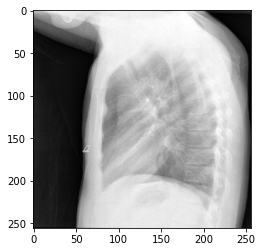

In [62]:
img = vx['image_input'][0]
plt.imshow(img)
print(img.min(),img.max())

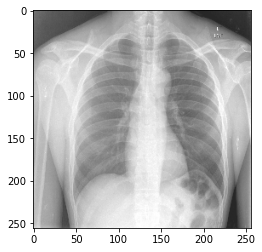

--- 0 ---
[2937_IM-1339-1001.dcm.png.jpg], 
 in_len: 2.0  
 input seq: ['<startseq> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']  
 mask: [array([1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array

In [63]:
plt.imshow(tr_x['image_input'][0])
plt.show()
for i in range(tr_x['image_names'].shape[0]):
#     print(tr_y['target_words'].argmax(-1))
    print('---',i,'---')
    print('['+tr_x['image_names'][i]+'], \n in_len:',tr_x['input_lengths'][i],' \n input seq:',tokenizer.sequences_to_texts(tr_x['words_input'][i:i+1]), ' \n mask:',list(tr_x['padding_masks'][i]), ' \n output seq:',tokenizer.sequences_to_texts(tr_x['y_true'][i:i+1]))

In [64]:
# print(vx['words_input'][1])
# embedding_matrix[105]

In [65]:
# emb_out = emb.predict(vx['words_input'])
# emb_out[1][-2]

In [66]:

# parallel_model=multi_gpu_model(model, gpus=n_gpu)
# # model_resnet.summary()
# # parallel_model.load_weights('./../checkpoints/sa_vgg16_3d_32x24_m32_direct.h5', by_name=True, skip_mismatch=True)

In [67]:
# lr=0.0001

# parallel_model.compile(loss=lambda y_true,y_pred:y_pred,optimizer=adam) #For multi GPU
# parallel_model.summary()

In [68]:
# mc=ModelCheckpoint(filepath='../checkpoints/vgg16_lstm_words.h5',monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
# es=EarlyStopping(patience=300,monitor='val_loss',min_delta=0.0001,mode='auto')

print('training {0} for {1} epochs'.format(model_name,EPOCHS))
# lr = K.eval(parallel_model.optimizer.lr)
# decay = 1e-3

training vgg_1dcnn_text_img_attention for 50 epochs


In [69]:
def CheckSelfAttention(input_data,labels):
    image_input,words_input,padding_masks,pos_enc=input_data
    for i in range(words_input.shape[0]):
        print('-*-*-',i,'-*-*-')
        print('input_seq:',', '.join(['<None> {0}'.format(y) if x==0 else '<{0}> {1}'.format(co_to_w[x],y) for x,y in zip(words_input[i],padding_masks[i])]),', \t next_word:',co_to_w[labels[i].argmax(-1)])
#     c1 = Model(textNet.inputs,textNet.get_layer('c1').output)
    c1 = Model(model.inputs,model.get_layer('c1').output)
    encoded_image = Model(model.inputs,model.get_layer('image_output_features').output)
    cond_enc = Model(model.inputs,model.get_layer('cond_enc_2').output)
    res_comb_NA_2 =  Model(model.inputs,model.get_layer('res_comb_FF_2').output)
#     t2i_concat_1 = Model(model.inputs,model.get_layer('text2img_concat_1').output)
    
    return [
        c1.predict(input_data),
        encoded_image.predict(input_data)
        ,cond_enc.predict(input_data)
        ,res_comb_NA_2.predict(input_data)
    ]
#             , textNet.predict(input_data[1:])]
#     print(concat_sa_2)
    
def ReduceLROnPlateau(decay=0.5):
    old_lr = K.eval(model.optimizer.lr)
    new_lr = old_lr * decay
    return old_lr,new_lr
# kl.LocallyConnected1D(filters=512,kernel_size=1,strides=1,padding='valid')

In [70]:
# ReduceLROnPlateau()
pos_encoding = NM.positional_encoding(max_wlen, dimensions=embedding_size)
pos_encoding.shape

(1, 60, 256)

In [71]:
patience = 2
patience_counter = 0
min_delta = 0.001

In [81]:
from IPython.display import clear_output

# counter = 0

# history = model.fit_generator(train_gen
#                               ,epochs=EPOCHS
#                               ,steps_per_epoch=4
#                               ,validation_data=val_gen
#                               ,validation_steps=2
#                               ,callbacks=[mc])

hist_tl,hist_ta,hist_vl,hist_va,tt,lr_arr = [],[],[],[],[],[]
train_iterations = int(np.ceil(len(img_name_train)/train_batch_size))
val_iterations = int(np.ceil(len(img_name_val)/val_batch_size))

print('train_iterations:{0}; val_iterations:{1}'.format(train_iterations,val_iterations))
min_v_l,min_v_a,min_t_a = 100,0,0
t_l, t_a, v_l, v_a = 0, 0, 4.01, 0

loss,accuracy=0.0,0.0
breakAll=False
train_gen = datagen(img_name_train,cap_train,batch_size=train_batch_size)
val_gen = datagen(img_name_val,cap_val,batch_size=val_batch_size)

for e in tqdm(np.arange(start=0,stop=EPOCHS),desc='Epoch'):
    

    start_time = time()
    tl,ta,vl,va = [],[],[],[]
    for im in tqdm(range(train_iterations),desc='Train_Iter',leave=False):
        if im%1000==0 and im>0:
            model.save_weights(filepath='../checkpoints/{0}_iu.h5'.format(model_name),overwrite=True)
        tx,ty = next(train_gen)
 
        
        _image_input = tx['image_input']
        _y_true = tx['y_true']
        _words_input = tx['words_input']
        _padding_masks = tx['padding_masks']
        _positional_encoding = np.repeat(pos_encoding,repeats=_image_input.shape[0],axis=0)
        _text_ytrue_len = tx['input_lengths']
        _text_ypred_len = tx['output_lengths'] 
        
        _out = ty['ctc']
#         print(len(inputs1))
#         train_st_idx = 0
#         val_st_idx = 0
#         for i in np.arange(len(inputs1)):
#             print('co_to_w[labels[{0}]]:{1}'.format(i,co_to_w[labels[i]]))
#             if 'endseq' in co_to_w[labels[i]]:
#                 print('co_to_w[labels[{0}]]:{1}'.format(i,co_to_w[labels[i]]))
#                 im_in,wo_in,m_in,labs = inputs1[train_st_idx:i+1] ,inputs2[train_st_idx:i+1] ,inputs3[train_st_idx:i+1] ,labels[train_st_idx:i+1] 
        
#         im_in,wo_in,m_in,labs = np.expand_dims(axis=0,a=inputs1[i]) , np.expand_dims(axis=0,a=inputs2[i]), np.expand_dims(axis=0,a=inputs3[i]), np.expand_dims(axis=0, a=labels[i])
#             print(im_in.shape,wo_in.shape,m_in.shape,labs.shape,pos_enc.shape)
#             print(' '.join([co_to_w[x] if x>0 else '<pad>' for x in wo_in[-1]]),[co_to_w[labs[-1].argmax(-1)]])

        loss = model.train_on_batch(x=[_image_input
                                       , _y_true
                                       , _words_input
                                       , _padding_masks
                                       , _positional_encoding               
                                       , _text_ytrue_len
                                       , _text_ypred_len]
                                        ,y=_out)
        if loss == np.inf:
            print('texts:',tokenizer.sequences_to_texts(_y_true),'loss:',loss)
#                 train_st_idx = i                                          
#             concat_sa_2,concat_sa_3,concat_sa_4,textNet_output = CheckSelfAttention([inputs2[i:i+window],inputs3[i:i+window]],labels[i:i+window])            
        if (np.isnan(model.get_layer('c1').get_weights()[0].sum())):
            print('break epoch:{0},i:{1},nan:c1'.format(e,i))
            breakAll=True
            break
        tl.append(loss)
        ta.append(accuracy)
        print('tr_loss:{0:.4f}, tr_acc:{1:.4f} (min_v_loss:{2:.4f})'
                  .format(np.mean(tl)
                              , np.mean(ta)
                              , min_v_l), end = '\r')
#             break
#         break
#     break

        if breakAll:
            print('break iteration:',breakAll)
            break
    if breakAll:
        print('break all:',breakAll)
#         breakAll=False
        break
    else:
        for im in tqdm(range(val_iterations),desc='Val_Iter',leave=False):
            
            vx,vy = next(val_gen)
            _image_input = vx['image_input']
            _y_true = vx['y_true']
            _words_input = vx['words_input']
            _padding_masks = vx['padding_masks']
            _positional_encoding = np.repeat(pos_encoding,repeats=_image_input.shape[0],axis=0)
            _text_ytrue_len = vx['input_lengths']
            _text_ypred_len = vx['output_lengths'] 

            _out = vy['ctc']
#             for i in np.arange(len(inputs1)):
#                 if co_to_w[labels[i]]=='endseq': 
# #                     print('co_to_w[labels[{0}]]:{1}'.format(i,co_to_w[labels[i]]))
#                     im_in,wo_in,m_in,labs = inputs1[val_st_idx:i+1],inputs2[val_st_idx:i+1],inputs3[val_st_idx:i+1],labels[val_st_idx:i+1]
            pos_enc = np.repeat(pos_encoding,repeats=_image_input.shape[0],axis=0)
            loss = model.evaluate(verbose=0
                                           , x=[_image_input
                                               , _y_true
                                               , _words_input
                                               , _padding_masks
                                               , _positional_encoding               
                                               , _text_ytrue_len
                                               , _text_ypred_len]
                                            , y = _out)
#                     val_st_idx = i 
            vl.append(loss)
            va.append(accuracy)
        v_l = np.round(np.mean(vl),4)
        v_a = np.round(np.mean(va),4)
        t_l = np.round(np.mean(tl),4)
        t_a = np.round(np.mean(ta),4)

        hist_tl.append(t_l)
        hist_ta.append(t_a)
        hist_vl.append(v_l)
        hist_va.append(v_a)
        if len(hist_tl)>=3:
            if hist_tl[-2]-hist_tl[-1]<min_delta:
                patience_counter+=1
                if patience==patience_counter:
                    old_lr,lr = ReduceLROnPlateau()
                    patience_counter = 0
#                     K.set_value(parallel_model.optimizer.lr,lr)
                    K.set_value(model.optimizer.lr,lr)
        lr_arr.append(lr)
        if v_l < min_v_l:
            min_v_l = v_l
            model.save_weights(filepath='../checkpoints/{0}_iu.h5'.format(model_name),overwrite=True)
    #         imgNet.save_weights(filepath='../checkpoints/{0}_{1}_img_module_vis_gen.h5'.format(img_arch,text_arch),overwrite=True)
    #         textNet.save_weights(filepath='../checkpoints/{0}_{1}_text_module_vis_gen.h5'.format(img_arch,text_arch),overwrite=True)
        clear_output(wait=True)
        end_time = time()
        time_taken = end_time-start_time
        tt.append(time_taken)
        with open('../tf_runs/log.csv','a') as f:
            data = '{0:3d}/{7},{1:.4f},{2:.4f},{3:.4f},{4:.4f},{6:.4f},{8:.6f}'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS,lr)
            t = strftime("%m/%d/%Y %H:%M:%S",localtime())
            f.writelines('\n[{0}],{1},{2}'.format(t, model_name,data))
        print('E:{0:3d}/{7}, tr_loss:{1:.4f}, tr_acc:{2:.4f}, v_loss:{3:.4f}, v_acc:{4:.4f}, lr:{8:.6f} [{5:.2f} s/e] (min_v_loss:{6:.4f})'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS,lr))

E:  4/50, tr_loss:55.9051, tr_acc:0.0000, v_loss:70.9647, v_acc:0.0000, lr:0.000100 [2670.71 s/e] (min_v_loss:70.4093)


tr_loss:52.7930, tr_acc:0.0000 (min_v_loss:70.4093)


KeyboardInterrupt: 

In [82]:
# ty['ctc']
pred_model = Model(inputs=[model.inputs[0],model.inputs[2],model.inputs[3],model.inputs[4]],outputs=[model.get_layer('y_pred').output])

In [83]:
train_gen = datagen(img_name_train,cap_train,batch_size=train_batch_size)
val_gen = datagen(img_name_val,cap_val,batch_size=val_batch_size)


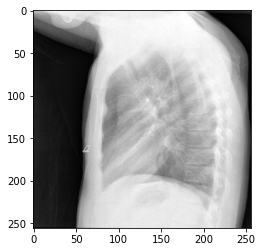

In [84]:
# tx['image_names'][i:i+window]
# im = Image.open('../../dataset/train_images/VG_100K/2391362.jpg')
# np.asarray(im)
tx,ty = next(val_gen)
inputs1 = tx['image_input']
inputs2 = tx['words_input']
# print(inputs2)
inputs3 = tx['padding_masks']
labels = tx['y_true'] 
plt.imshow(inputs1[0])
plt.show()
preds,act=[],[]
# for i in np.arange(len(inputs1)):
#             print('co_to_w[labels[{0}]]:{1}'.format(i,co_to_w[labels[i]]))
#             if 'endseq' in co_to_w[labels[i]]:
#                 print('co_to_w[labels[{0}]]:{1}'.format(i,co_to_w[labels[i]]))
#                 im_in,wo_in,m_in,labs = inputs1[train_st_idx:i+1] ,inputs2[train_st_idx:i+1] ,inputs3[train_st_idx:i+1] ,labels[train_st_idx:i+1] 
#                 print(' '.join([co_to_w[x] if x>0 else '<pad>' for x in wo_in[-1]]),[co_to_w[labs[-1]]])
pos_enc = np.repeat(pos_encoding,repeats=inputs1.shape[0],axis=0)
ctc_preds = pred_model.predict([inputs1,inputs2,inputs3,pos_enc])
preds = ctc_preds.argmax(-1)
# print(preds)
# print(act)


In [85]:
pd.options.display.max_colwidth=0
pd.options.display.max_rows=1000
pred_df = pd.DataFrame()
pred_df['input_words']=tokenizer.sequences_to_texts(inputs2)
pred_df['actual']=tokenizer.sequences_to_texts(labels)
pred_df['preds']=tokenizer.sequences_to_texts(preds)
pred_df

,input_words,actual,preds
0,<startseq> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart silhouette normal in size no within normal limits no the pleural pleural are no no no effusion effusion effusion or or effusion are acute acute acute <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq>
1,<startseq> the <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart silhouette normal in size no within normal limits no the pleural pleural are no no no effusion effusion effusion or or effusion are acute acute acute <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq>
2,<startseq> the heart <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart is <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart silhouette normal in size no within normal limits no the pleural pleural are no no no effusion effusion effusion or or effusion are acute acute acute <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq> <endseq>
3,<startseq> the heart is <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart is normal <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

In [86]:
print(ctc_preds.shape)#,print(10*np.ones(ctc_preds.shape[0]))
decoded = K.ctc_decode(y_pred=ctc_preds, input_length=(tx['input_lengths']) ,greedy=False, beam_width=10, top_paths=1)
paths = [path.eval(session=K.get_session()) for path in decoded[0]]
paths

(289, 60, 2000)


[array([[ 2, 17, -1, ..., -1, -1, -1],
        [ 2, 17, 27, ..., -1, -1, -1],
        [ 2, 17, 27, ..., -1, -1, -1],
        ...,
        [ 2, 17, 27, ..., -1, -1, -1],
        [ 2, 17, 27, ..., -1, -1, -1],
        [ 2, 17, 27, ..., -1, -1, -1]])]

In [87]:

pd.options.display.max_colwidth=0
pd.options.display.max_rows=1000
pred_df = pd.DataFrame()
pred_df['input_words']=tokenizer.sequences_to_texts(inputs2)
pred_df['actual']=tokenizer.sequences_to_texts(labels)
pred_df['preds']=tokenizer.sequences_to_texts(paths[0])
pred_df


,input_words,actual,preds
0,<startseq> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
1,<startseq> the <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart silhouette <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
2,<startseq> the heart <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart is <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart silhouette normal <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
3,<startseq> the heart is <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart is normal <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart silhouette normal in <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
4,<startseq> the heart is normal <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,the heart is normal size <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [ ]:
concat_sa_2,concat_sa_3,concat_sa_4,textNet_output = CheckSelfAttention([inputs2[i:i+window],inputs3[i:i+window]],labels[i:i+window])            
# 

In [ ]:
pd.DataFrame(concat_sa_2[1])

In [ ]:
pd.DataFrame(concat_sa_3[1])

In [ ]:
# pd.DataFrame(concat_sa_4[1])

In [ ]:
pd.DataFrame(textNet_output[1])

In [ ]:
# with open('../tf_runs/log.csv','a') as f:
#     data = '{0:3d}/{7},{1:.4f},{2:.4f},{3:.4f},{4:.4f},{6:.4f}'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS)
#     t = strftime("%m/%d/%Y %H:%M:%S",localtime())
#     f.writelines('\n[{0}],{1},{2}'.format(t, model_name,data))
# data

In [ ]:
history = pd.DataFrame()
history['tr_acc'] = hist_ta
history['val_acc'] = hist_va
history['tr_loss'] = hist_tl
history['val_loss'] = hist_vl
display(history[['tr_acc','val_acc']].plot())
display(history[['tr_loss','val_loss']].plot())
history.to_csv('../tf_runs/{0}_x_delete.csv'.format(model_name),index=False)

# Evaluate

In [ ]:
model.load_weights('../checkpoints/{0}.h5'.format(model_name))

In [ ]:

def predict_captions(image):
    start_word = ["startseq"]
    mask = np.zeros((1,max_wlen,1))+1e-6
    counter=0
    while True:
        counter-=1
        mask[:,counter,:]=1.0
        print(np.sum(mask))
        par_caps = [w_to_co[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_wlen, padding='pre',value=0)
        pos_enc = np.repeat(pos_encoding,repeats=image.shape[0],axis=0)
        preds = model.predict([image, np.array(par_caps),mask,pos_enc])
#         print(preds.shape)
        idx = preds.argmax(-1)
        word_pred = co_to_w[idx[0]]
#         print(par_caps)
        start_word.append(word_pred)
        
        if word_pred == "endseq" or len(start_word) > max_wlen:
            break
            
    return ' '.join(start_word[1:-1])

# print('Predicted:',' '.join(out_text))

In [ ]:
[tokenizer.word_index["<startseq>"]]

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [tokenizer.word_index["<startseq>"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    mask = np.zeros((1,max_wlen,1))+1e-6
    counter=0
    while len(start_word[0][0]) < max_wlen:
        temp = []
        counter-=1
        mask[:,counter,:]=1.0
#         print(np.sum(mask))
        for s in start_word:
            pos_enc = np.repeat(pos_encoding,repeats=image.shape[0],axis=0)
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_wlen, padding='post', value=0)
            preds = model.predict([image, np.array(par_caps),mask,pos_enc])
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [co_to_w[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
ref_sents = []
pred_sents = []
for counter in tqdm(range(len(test_images_list))):
    testx,testy = next(test_gen)
    photo = testx['image_input'][0]
#     plt.imshow(photo)
#     plt.show()
    photo = np.expand_dims(photo,0)
    
#     print('Actual:',testy['actual_sentence'][0])
#     print()
    # st = time()
    # pred_greedy = predict_captions(photo)
    # et = time()
    # print('Greedy Predicted:{0},[{1:.2f} s]'.format(pred_greedy,et-st))
#     st = time()
    pred_bm5 = beam_search_predictions(photo,beam_index=5)
#     et = time()
#     print('Beam-5 Predicted:{0},[{1:.2f} s]'.format(pred_bm5,et-st))
    ref_sents.append(testy['actual_sentence'][0])
    pred_sents.append(pred_bm5)
    if counter==10:
        break

In [ ]:

# st = time()
# pred_greedy = predict_captions(photo)
# et = time()
# print('Greedy Predicted:{0},[{1:.2f} s]'.format(pred_greedy,et-st))

# st = time()
# pred_bm3 = beam_search_predictions(photo,beam_index=3)
# et = time()
# print('Beam-3 Predicted:{0},[{1:.2f} s]'.format(pred_bm3,et-st))

# st = time()
# pred_bm5 = beam_search_predictions(photo,beam_index=5)
# et = time()
# print('Beam-5 Predicted:{0},[{1:.2f} s]'.format(pred_bm5,et-st))

# st = time()
# pred_bm7 = beam_search_predictions(photo,beam_index=7)
# et = time()
# print('Beam-7 Predicted:{0},[{1:.2f} s]'.format(pred_bm7,et-st))
pd.set_option('display.max_colwidth', -1)
df_pred = pd.DataFrame()
df_pred['Ref'] = ref_sents
df_pred['Pred'] = pred_sents
df_pred

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
rouge = Rouge()
reference = nlp(str(vy['actual_sentence'][0]))
reference = [[str(x) for x in list(reference)]]


# candidate = nlp(pred_greedy)
# candidate = [str(x) for x in list(candidate)]
# df_result['greedy'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]

# candidate = nlp(pred_bm3)
# candidate = [str(x) for x in list(candidate)]
# df_result['bm3'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]
row = []
for i in range(len(ref_sents)):
    r = ref_sents[i]
    c = pred_sents[i]
    reference = nlp(str(r))
    reference = [[str(x) for x in list(reference)]]
    candidate = nlp(str(c))
    candidate = [str(x) for x in list(candidate)]
    row.append([sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
                          ,rouge.get_scores(hyps=c,refs=r)[0]['rouge-l']['f']])


# candidate = nlp(pred_bm7)
# candidate = [str(x) for x in list(candidate)]
# df_result['bm7'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]
df_result = pd.DataFrame(row)
df_result.columns = ['BLEU-1','BLEU-2','BLEU-3','BLEU-4','ROUGE-L']
df_result=df_result.round(3)

In [ ]:
# ref_sents,pred_sents
df_result.mean()

In [ ]:
pd.DataFrame(row)

In [ ]:

reference = str(vy['actual_sentence'][0])
# reference = [[str(x) for x in list(reference)]]
candidate = pre
# candidate = [str(x) for x in list(candidate)]
ro = rouge.get_scores(hyps=candidate,refs=reference)
ro[0]['ROUGE-L']['f']

In [ ]:
pd.DataFrame(ro[0]).T

In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

In [ ]:
def calc_scores(ref, hypo):
    """
    ref, dictionary of reference sentences (id, sentence)
    hypo, dictionary of hypothesis sentences (id, sentence)
    score, dictionary of scores
    """
    scorers = [
#         (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
#         (Meteor(),"METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores 

In [ ]:
calc_scores(ref=ref_sents,hypo=pred_sents)

In [ ]:
from nlgeval import NLGEval
nlgeval = NLGEval()  # loads the models


In [ ]:
references = []
hypothesis = []
import pickle
import numpy as np
with open('../dataset/chestxray_cnn_attention_decoder_ref_sents.p', 'rb') as file:
    # store the data as binary data stream
    references=pickle.load(file)
with open('../dataset/chestxray_cnn_attention_decoder_pred_sents.p', 'rb') as file:
    # store the data as binary data stream
    hypothesis=pickle.load(file)
    
references=np.array(references)
hypothesis=np.array(hypothesis)
references[:2],hypothesis[:2]

In [ ]:
refs=np.expand_dims(ref_sents,1)
# hyps=np.expand_dims(hypothesis,0)
refs=refs.tolist()
# hyps=hyps.tolist()
hypothesis = pred_sents
len(refs),len(hypothesis)

In [ ]:
metrics_dict = nlgeval.compute_metrics(refs, hypothesis)

In [ ]:
r = {idx: strippedlines for (idx, strippedlines) in enumerate(refs)}

In [ ]:
len(r)

In [ ]:
h = {idx: [lines.strip()] for (idx, lines) in enumerate(hypothesis)}

In [ ]:
len(h)

In [ ]:
refs[0],hypothesis[0]

In [ ]:
from nlgeval import compute_individual_metrics


In [ ]:
metrics_dict = compute_individual_metrics(refs[1], hypothesis[1])

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(metrics_dict,orient='index').T

In [ ]:
df = pd.DataFrame()
for i in range(300):
    m = nlgeval.compute_individual_metrics(refs[i], hypothesis[i])
    d = pd.DataFrame.from_dict(m,orient='index').T
    df = df.append(d)
    print(np.around(i*100//300,2),end='\r')

In [ ]:
df.shape
kl.LSTM(units=512,dropout=0.2,recurrent_dropout=0.2
                       ,activation=activation
                       , return_sequences=True
                       , name = 'c_out')(dec_2)

In [ ]:
df.mean()

In [ ]:
testx,testy = next(test_gen)
plt.imshow(testx['image_input'][1])

In [ ]:
testx.keys()

In [ ]:
for layer  in model.layers:
    print(layer.name)

In [ ]:
model_img2_text_ca_1 = Model(model.inputs,model.get_layer('img2text_1').output)
model_img2_text_ca_2 = Model(model.inputs,model.get_layer('img2text_2').output)
model_img2_text_ca_3 = Model(model.inputs,model.get_layer('img2text_3').output)
model_img2_text_ca_4 = Model(model.inputs,model.get_layer('img2text_4').output)
# model_text2_img_ca_1 = Model(model.inputs,model.get_layer('text2img_1').output)
# model_text2_img_ca_2 = Model(model.inputs,model.get_layer('text2img_2').output)
# model_text2_img_ca_3 = Model(model.inputs,model.get_layer('text2img_3').output)
# model_text2_img_ca_4 = Model(model.inputs,model.get_layer('text2img_4').output)

In [ ]:
fi2t_1,bi2t_1 = model_img2_text_ca_1.predict(testx)
fi2t_2,bi2t_2 = model_img2_text_ca_2.predict(testx)
fi2t_3,bi2t_3 = model_img2_text_ca_3.predict(testx)
fi2t_4,bi2t_4 = model_img2_text_ca_4.predict(testx)
# ft2i_1,bt2i_1 = model_text2_img_ca_1.predict(testx)
# ft2i_2,bt2i_2 = model_text2_img_ca_2.predict(testx)
# ft2i_3,bt2i_3 = model_text2_img_ca_3.predict(testx)
# ft2i_4,bt2i_4 = model_text2_img_ca_4.predict(testx)

In [ ]:
fi2t_1.shape,bi2t_1.shape

In [ ]:
# bt2i_add = bt2i_1+bt2i_1+bt2i_1+bt2i_1
bi2t_add = bi2t_1+bi2t_1+bi2t_1+bi2t_1

In [ ]:
# bt2i_add.shape
bi2t_add.shape

In [ ]:
# for j in range(bt2i_add.shape[0]):    
#     i=testx['words_input'][j][-1]
#     if i!=0:
#         print(j,':',co_to_w[i])
#         plt.imshow(bt2i_add[j])
#         plt.show()
for j in range(bi2t_add.shape[0]):    
    i=testx['words_input'][j][-1]
    if i!=0:
        print(j,':',co_to_w[i])
        plt.imshow(bi2t_add[j])
        plt.show()

In [ ]:

for i in range(pd.DataFrame(bt2i_add[j]).shape[0]):
    print('Row:{0},Max Col Idx:{1},Max Col Value:{2}'.format(i,np.argmax(bt2i_add[j][i]),np.max(bt2i_add[j][i])))

In [ ]:
plt.imshow(cv2.resize(bt2i_add[j][57].reshape((8,8)),(256,256),cv2.INTER_CUBIC),cmap='jet')

In [ ]:
plt.imshow(testx['image_input'][1])
plt.imshow(cv2.resize(bt2i_add[j][57].reshape((8,8)),(256,256),cv2.INTER_CUBIC),cmap='jet',alpha=0.2)

In [ ]:
testx['words_input'].shape